<a href="https://colab.research.google.com/github/lavanyashukla/CycleGAN/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Space Invaders



In [1]:
!pip install wandb -qq

     |████████████████████████████████| 1.4MB 9.6MB/s 
     |████████████████████████████████| 102kB 16.7MB/s 
     |████████████████████████████████| 102kB 15.5MB/s 
     |████████████████████████████████| 102kB 14.8MB/s 
     |████████████████████████████████| 460kB 63.1MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 71kB 12.7MB/s 


In [2]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime
import wandb
wandb.init(project="qualcomm")

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


W&B Run: https://app.wandb.ai/lavanyashukla/qualcomm/runs/ujk9fass

## Preprocessing - crop images, convert them to 1D black and white image tensors

- Image dimensions - (210, 160, 3)
- Output dimensions - (88, 80, 1)


In [0]:
color = np.array([210, 164, 74]).mean()

def preprocess_frame(obs):
    # Crop and resize
    img = obs[25:201:2, ::2]

    # Convert to greyscale
    img = img.mean(axis=2)

    # Improve contrast
    img[img==color] = 0

    # Normalzie image
    img = (img - 128) / 128 - 1

    # Reshape to 80*80*1
    img = img.reshape(88,80)

    return img 

## Initialize gym environment and explore game screens


6
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


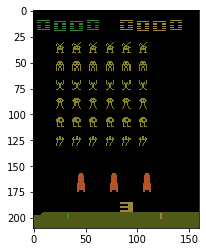

In [4]:
env = gym.make("SpaceInvaders-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

observation = env.reset()
# Game Screen
for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()
  observation, _, _, _ = env.step(1)

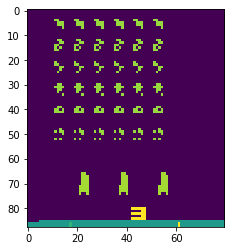

In [5]:
# Preprocessed Game Screen
obs_preprocessed = preprocess_frame(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()

## Frame stacking and composition

Useful in detecting motion in frames - Returns an element wise max sum of 2 frames - a technique from the deepmind paper. This allows the agent to select an action based on the last few screens, not just the last screen.

In [0]:
stack_size = 4

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((88,80), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear stacked_frames
        stacked_frames = deque([np.zeros((88,80), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Copy the same frame 4x for the new episode, apply elementwise maxima
        maxframe = np.maximum(frame,frame)
        stacked_frames.append(maxframe)
        stacked_frames.append(maxframe)
        stacked_frames.append(maxframe)
        stacked_frames.append(maxframe)
        
        # Stack frames
        stacked_state = np.stack(stacked_frames, axis=2)
    else:
        # Fetch rightmost element as the deque append adds t to the right
        maxframe=np.maximum(stacked_frames[-1],frame)
        # Append frame to deque - removes the oldest frame
        stacked_frames.append(maxframe)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

## Define hyperparameters

In [0]:
wandb.config.num_episodes = 100
wandb.config.batch_size = 48
wandb.config.discount_factor = 0.97
wandb.config.learning_rate = 0.001

copy_steps = 100
global_step = 0
steps_train = 4
start_steps = 2000
input_shape = (None, 88, 80, 1)
# This is the modified shape with stacked frames
X_shape = (None, 88, 80, 4)

## Define deep Q network
Has 4 conv layers and a fully connected layer that outputs the probabilities of taking each action in the game space.

In [0]:
tf.compat.v1.reset_default_graph()
def q_network(X, name_scope):
    
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

    with tf.compat.v1.variable_scope(name_scope) as scope: 
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)

        layer_4 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_4',layer_4)
        
        flat = flatten(layer_4)

        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)

        output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)

        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        return vars, output

## Implement epsilon-greedy policy

Set epsilon values to trade between exploratory (random) and next best actions. It starts out with only (epsilon=) 5% of actions being random and slowly increases this number.




In [0]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if p< epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

## Evaluate current policy and store variables in a buffer to use during mini batch training

This stores the agent's state, action, and reward information in the experience replay buffer. We use this buffer to update our network weights while training.

In [0]:
buffer_len = 20000
exp_buffer = deque(maxlen=buffer_len)

In [0]:
# sample experiences from the memory according to batches
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]


In [0]:
logdir = 'logs'
tf.compat.v1.reset_default_graph()

# placeholder for our input i.e game state
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# toggle training
in_training_mode = tf.compat.v1.placeholder(tf.bool)

## Build the primary and target Q networks

This lets training and data generation happen at the same time.

In [13]:
# primary Q network - and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [0]:
# placeholder for action values
X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)


In [0]:
# Copy primary Q network params to target Q network
copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)


## Define the loss and optimizer

Loss = (target action (action with the highest value) - predicted action)^2

In [0]:
# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(wandb.config.learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())


## Render gameplay in the gym env

In [17]:
# Visualize in colab

# Install dependencies first for graphics visualization within Colaboratory
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (45.1.0)


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

## Train the network

Takes as input a stack of greyscale images (88,88,4), generates a probability distribution of next actions.

Uses the epsilon-greedy policy to tradeoff between next ebst action and random exploratory action and select the next action.

For a predefined # of steps - Feed next action into the network and get the next state and rewards, store them into the buffer. Pick next action using epsilon-greedy policy and repeat. Perform gradient descent in order to minimize the loss.

In [1]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    # for each episode
    history = []
    for i in range(wandb.config.num_episodes):
        done = False
        environment = Monitor(env, './video', force=True)
        obs = environment.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []
        
        # begin stacking frames
        obs,stacked_frames= stack_frames(stacked_frames,obs,True)

        # while the state is not the terminal state
        while not done:

           # Data generation using the untrained network
            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER    
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            environment.render()
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = environment.step(action)

            #Begin stacking intra-episode code
            next_obs, stacked_frames = stack_frames(stacked_frames, next_obs, False)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, next_obs, reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                #Our buffer should already contain everything preprocessed and stacked
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(wandb.config.batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})

                # discounted reward: these are our Y-values
                y_batch = o_rew + wandb.config.discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # to calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)

                # ;og loss into wandb
                wandb.log({'loss': train_loss})
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward

        next_obs=np.zeros(obs.shape)
        exp_buffer.append([obs, action, next_obs, reward, done])
        obs= environment.reset()
        obs,stacked_frames= stack_frames(stacked_frames,obs,True) 
        
        history.append(episodic_reward)

        # log reward into wandb
        wandb.log({'reward': episodic_reward})
        environment.close()

        # render video
        mp4list = glob.glob('video/*.mp4')
        if len(mp4list) > 0:
          print(len(mp4list))
          mp4 = mp4list[-1]
          video = io.open(mp4, 'r+b').read()
          encoded = base64.b64encode(video)

          # log video into wandb
          wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})
          ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                  </video>'''.format(encoded.decode('ascii'))))
        else: 
          print("Could not find video")
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))
    



NameError: ignored